# Naive Model Power Estimation

The following model(s) uses two files as inputs to perform the calculation, and a third file that contains the true values to compare the results with.

### Input files are:
True data values file:
- Benchmarks data (code, power)
- Instructions data (instruction : (power, cycles))

Profiling file:
- Benchmark profile (code, (instruction : instruction_count))


### Models
Two naive models are introduced:
- model 1: <br>
    $P_{avg} = \frac{1}{\sum I_{count}} \sum \limits_{i=1}^{N} P_{i} \cdot I_{count}$
- model 2: <br>
    $P_{avg} = \frac{1}{\sum I_{count} \cdot Cycles_{i}} \sum \limits_{i=1}^{N} P_{i} \cdot I_{count} \cdot Cycles_{i}$

In [8]:
import json

inst_regex = {
        "mov": "MOV",
        "mvn": "MOV",
        "ldr": "LDR",
        "bl": "BRANCH",
        "push": "PUSH",
        "add": "AND",
        "sub": "SUB",
        "str": "STR",
        "lsl": "LSL",
        "orr": "EOR",
        "ldrd": "LDR",
        "mul": "MUL",
        "umull": "MUL",
        "lsr": "LSR",
        "ldm": "LDR",
        "stm": "STR",
        "stmia": "STR",
        "asr": "ASR",
        "b": "BRANCH",
        "cmp": "CMP",
        "blt": "BRANCH",
        "bge": "BRANCH",
        "nop": "MOV",
        "pop": "POP",
        "bx": "BRANCH",
        "bgt": "BRANCH",
        "ble": "BRANCH",
        "bne": "BRANCH"
    }

def naive_model_1(inst_data_dict, benchmark_prof_dict):
    """This function represent the estimation of the average power according to the first Naive model.
        Inputs:
        - inst_data_dict: contains the power average per inst and nb of cycles. ({<inst>: { <power>: #power, <cycles>: #cycles}})
        - benchmark_prof_dict: contains profling data of each benchmark, occurence of each instruction in a code."""
    
    power_avg = 0
    denominator = 0

    for inst, count in benchmark_prof_dict.items():
        power_avg += inst_data_dict[inst_regex[inst]]['power']*count
        denominator += count
    return power_avg/denominator


def naive_model_2(inst_data_dict, benchmark_prof_dict):
    
    power_avg = 0
    denominator = 0

    for inst, count in benchmark_prof_dict.items():
        power_avg += inst_data_dict[inst_regex[inst]]['voltage']*count*inst_data_dict[inst_regex[inst]]['cycles']
        denominator += count*inst_data_dict[inst_regex[inst]]['cycles']
    return power_avg/denominator

def read_json_file(file_path):
    with open(file_path, 'r') as f:
        return json.load(f)
    
def relative_error(true_list, estimation_list):
    relative_error_list = []
    for i in range(len(estimation_list)):
        relative_error_list.append(100*abs(estimation_list[i]-true_list[i])/true_list[i])
    return relative_error_list

def save_results_as_json_file(file_path, data):
    with open(file_path, 'w') as j_file:
        json.dump(data, j_file)

### Apply Estimation Models

### Energy files preparation

In [10]:
inst_data = read_json_file("energy_files/voltage_instruction_data.json")
bench_prof = read_json_file("energy_files/benchmarks_profile.json")
bench_true_data = read_json_file("results/benchmarks_data.json")

estimation_benchmark_list = ["matrix_conv", "factorial", "matrix_mult", "matrix_mult_3x3", "fibonacci", "fibonacci_40", "median_filter", "qsort", "qsort_14"]
true_benchmark_list = ["matrix_conv_50MHz", "Factorial_100MHz", "matrix_mult_100MHz", "matrix_mult_50MHz_3x3", "fibonacci_100MHz", "fibonacci_100MHz_40", "median_filter_50MHz", "qsort_50MHz", "qsort_50MHz_14"]

volt_dict = {
    "voltage": {},
    "cycles": {}
}

for e in range(len(estimation_benchmark_list)):
    volt_dict['voltage'][estimation_benchmark_list[e]] = naive_model_2(inst_data, bench_prof[estimation_benchmark_list[e]])
    volt_dict['cycles'][estimation_benchmark_list[e]] = bench_true_data[true_benchmark_list[e]]['cycles']
save_results_as_json_file("energy_files/estimation_voltage_benchmark.json", volt_dict)

### Analyzing Models

In [2]:
inst_data = read_json_file("results/instructions_data.json")
bench_prof = read_json_file("results/benchmarks_profile.json")
bench_true_data = read_json_file("results/benchmarks_data.json")

estimation_benchmark_list = ["matrix_conv", "factorial", "matrix_mult", "matrix_mult_3x3", "fibonacci", "fibonacci_40", "median_filter", "qsort", "qsort_14"]
true_benchmark_list = ["matrix_conv_50MHz", "Factorial_100MHz", "matrix_mult_100MHz", "matrix_mult_50MHz_3x3", "fibonacci_100MHz", "fibonacci_100MHz_40", "median_filter_50MHz", "qsort_50MHz", "qsort_50MHz_14"]

estimated_power_avg_1 = [naive_model_1(inst_data, bench_prof[e]) for e in estimation_benchmark_list]
estimated_power_avg_2 = [naive_model_2(inst_data, bench_prof[e]) for e in estimation_benchmark_list]
true_power_avg = [bench_true_data[d]['power'] for d in true_benchmark_list]


## Relative Error

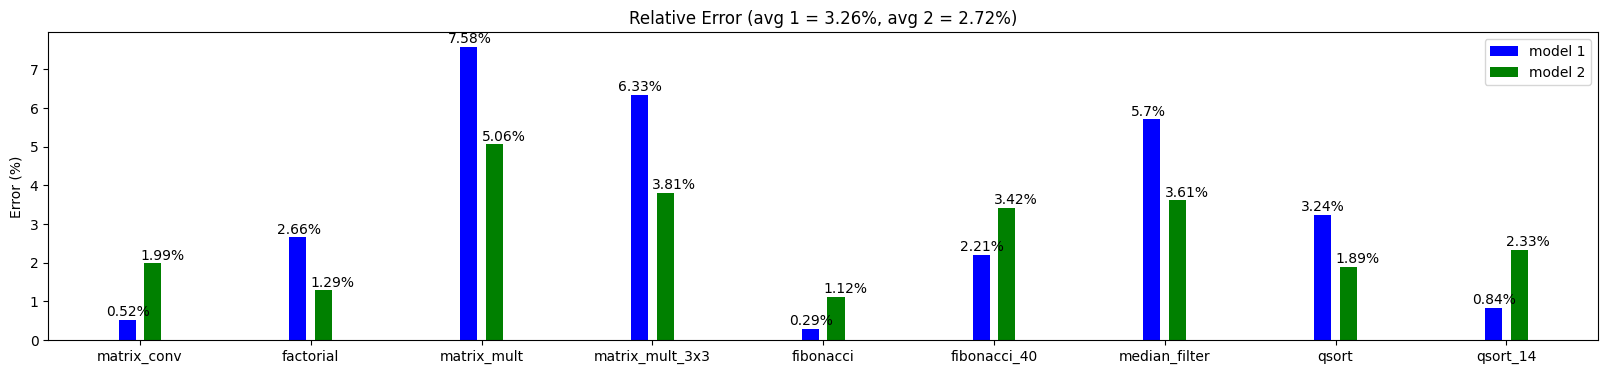

In [3]:
from statistics import mean
import matplotlib.pyplot as plt
import numpy as np

assert len(estimated_power_avg_1) == len(true_power_avg)
assert len(estimated_power_avg_2) == len(true_power_avg)

relative_error_1 = relative_error(true_power_avg, estimated_power_avg_1)
relative_error_2 = relative_error(true_power_avg, estimated_power_avg_2)

avg_rel_error_1 = round(mean(relative_error_1), 2)
avg_rel_error_2 = round(mean(relative_error_2), 2)

x = np.arange(len(true_power_avg)) # calculate nb of columns

w = 0.15
width = 0.1

plt.figure(figsize=(20, 4))
ax = plt.subplot(111)
ax.bar(x-w/2, relative_error_1, width=width, color='b', align='center')
ax.bar(x+w/2, relative_error_2, width=width, color='g', align='center')

for i, v in enumerate(relative_error_1):
    plt.text(i-0.2, v+0.1, str(round(v, 2))+"%")

for i, v in enumerate(relative_error_2):
    plt.text(i, v+0.1, str(round(v, 2))+"%")

plt.title(f'Relative Error (avg 1 = {avg_rel_error_1}%, avg 2 = {avg_rel_error_2}%)')
plt.xticks(x, estimation_benchmark_list)
plt.ylabel('Error (%)')
plt.legend(['model 1', 'model 2'])

plt.show()

### Model 1 (Cycles not considered)

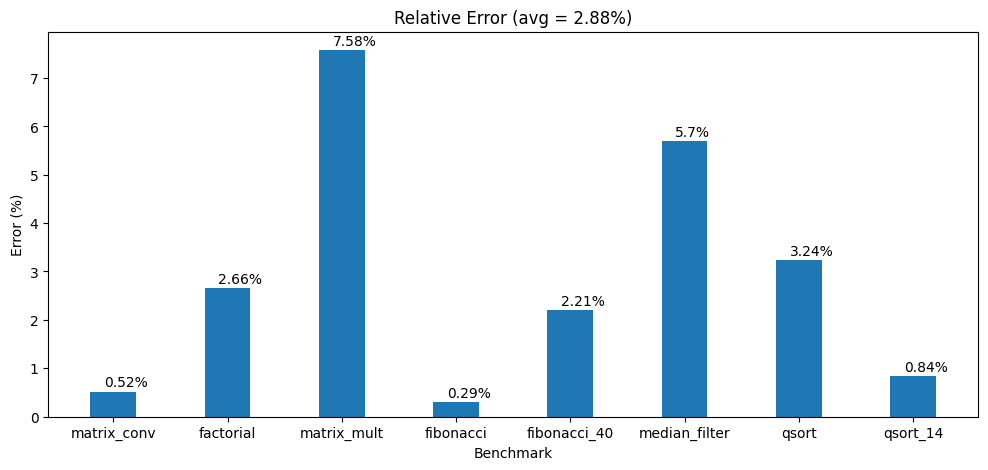

In [13]:
from statistics import mean
import matplotlib.pyplot as plt

assert len(estimated_power_avg_1) == len(true_power_avg)

relative_error_dict = {}
for i in range(len(estimated_power_avg_1)):
    relative_error_dict[estimation_benchmark_list[i]] = 100*abs(estimated_power_avg_1[i]-true_power_avg[i])/true_power_avg[i]

avg_rel_error = round(mean(relative_error_dict.values()), 2)
plt.figure(figsize=(12, 5))
plt.title(f"Relative Error (avg = {avg_rel_error}%)")
plt.bar(relative_error_dict.keys(), relative_error_dict.values(), width=0.4, align= 'center')
for i, v in enumerate(relative_error_dict.values()):
    plt.text(i-0.08, v+0.1, str(round(v, 2))+"%")
plt.xlabel("Benchmark")
plt.ylabel("Error (%)")
plt.show()


### Model 2 (multiplied by cycles weight)

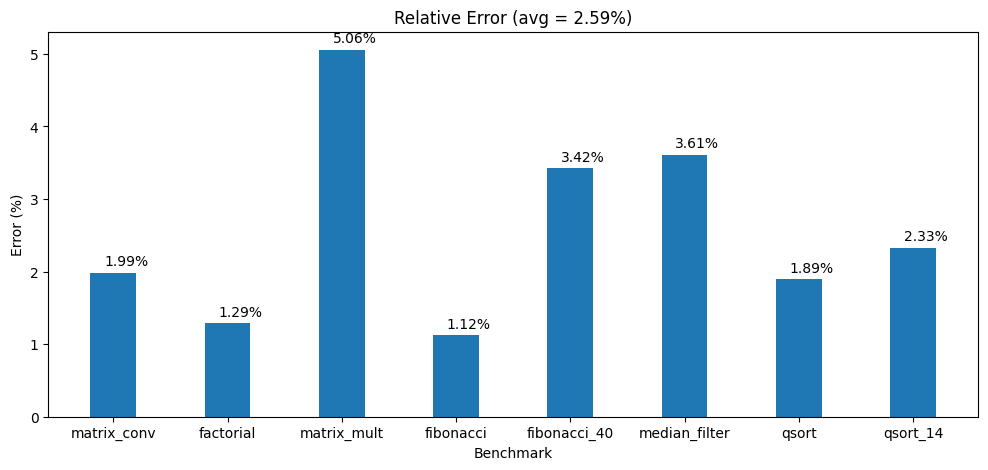

In [14]:
from statistics import mean
import matplotlib.pyplot as plt

assert len(estimated_power_avg_2) == len(true_power_avg)

relative_error_dict = {}
for i in range(len(estimated_power_avg_2)):
    relative_error_dict[estimation_benchmark_list[i]] = 100*abs(estimated_power_avg_2[i]-true_power_avg[i])/true_power_avg[i]

avg_rel_error = round(mean(relative_error_dict.values()), 2)
plt.figure(figsize=(12, 5))
plt.title(f"Relative Error (avg = {avg_rel_error}%)")
plt.bar(relative_error_dict.keys(), relative_error_dict.values(), width=0.4, align= 'center')
for i, v in enumerate(relative_error_dict.values()):
    plt.text(i-0.08, v+0.1, str(round(v, 2))+"%")
plt.xlabel("Benchmark")
plt.ylabel("Error (%)")
plt.show()

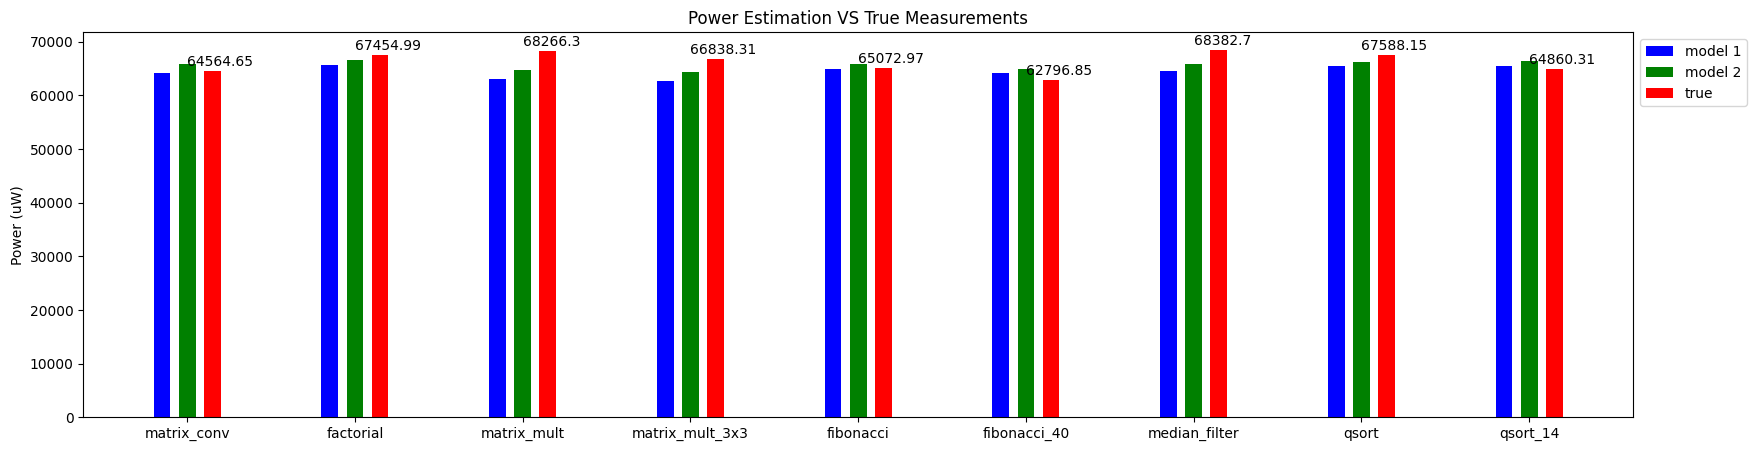

In [13]:
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(len(estimation_benchmark_list))

w = 0.15
width = 0.1

plt.figure(figsize=(20, 5))
ax = plt.subplot(111)
ax.bar(x-w, estimated_power_avg_1, width=width, color='b', align='center', label='model 1')
ax.bar(x, estimated_power_avg_2, width=width, color='g', align='center', label='model 2')
ax.bar(x+w, true_power_avg, width=width, color='r', align='center', label='true')

for i, v in enumerate(true_power_avg):
    plt.text(i, v+1e3, str(round(v, 2)))

plt.title('Power Estimation VS True Measurements')
plt.xticks(x, estimation_benchmark_list)
plt.ylabel('Power (uW)')
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')

plt.show()